## Libraries

In [1]:
import numpy as np
import pandas as pd

from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
import pickle

from sklearn.linear_model import LogisticRegression 

import matplotlib.pyplot as plt
import matplotlib.axes as axs
import seaborn as sns
sns.set()

from sklearn.linear_model import LinearRegression

## Data Preparation

In [2]:
df_purchase = pd.read_csv('purchase data.csv')


scaler = pickle.load(open('scaler.pickle', 'rb'))

pca = pickle.load(open('pca.pickle', 'rb'))

kmeans_pca = pickle.load(open('kmeans_pca.pickle', 'rb'))

features = df_purchase[['Sex', 'Marital status', 'Age', 'Education', 'Income', 'Occupation', 'Settlement size']]
df_purchase_segm_std = scaler.transform(features)

df_purchase_segm_pca = pca.transform(df_purchase_segm_std)

purchase_segm_kmeans_pca = kmeans_pca.predict(df_purchase_segm_pca)


df_purchase_predictors = df_purchase.copy()

df_purchase_predictors['Segment'] = purchase_segm_kmeans_pca
segment_dummies = pd.get_dummies(purchase_segm_kmeans_pca, prefix = 'Segment', prefix_sep = '_')
df_purchase_predictors = pd.concat([df_purchase_predictors, segment_dummies], axis = 1)

df_pa = df_purchase_predictors

## Purchase Probability Model

In [3]:
Y = df_pa['Incidence']

In [4]:
X = pd.DataFrame()
X['Mean_Price'] = (df_pa['Price_1'] +
                   df_pa['Price_2'] +
                   df_pa['Price_3'] +
                   df_pa['Price_4'] +
                   df_pa['Price_5'] ) / 5

In [5]:
model_purchase = LogisticRegression(solver = 'sag')
model_purchase.fit(X, Y)

LogisticRegression(solver='sag')

In [6]:
model_purchase.coef_

array([[-2.34878408]])

- The coefficients for price. It is negative, signaling that with an increase in price, the purchase probability decreases.

## Price Elasticity of Purchase Probability

In [7]:
df_pa[['Price_1', 'Price_2', 'Price_3', 'Price_4', 'Price_5']].describe()

,Price_1,Price_2,Price_3,Price_4,Price_5
count,58693.000000,58693.000000,58693.000000,58693.000000,58693.000000
mean,1.392074,1.780999,2.006789,2.159945,2.654798
std,0.091139,0.170868,0.046867,0.089825,0.098272
min,1.100000,1.260000,1.870000,1.760000,2.110000
25%,1.340000,1.580000,1.970000,2.120000,2.630000
50%,1.390000,1.880000,2.010000,2.170000,2.670000
75%,1.470000,1.890000,2.060000,2.240000,2.700000
max,1.590000,1.900000,2.140000,2.260000,2.800000


In [8]:
# Choosing a price range between 0.5 and 3.5, which somewhat expands the actual observed price range, 
# which is from 1.1 to 2.8. 
price_range = np.arange(0.5, 3.5, 0.01)
price_range

array([0.5 , 0.51, 0.52, 0.53, 0.54, 0.55, 0.56, 0.57, 0.58, 0.59, 0.6 ,
       0.61, 0.62, 0.63, 0.64, 0.65, 0.66, 0.67, 0.68, 0.69, 0.7 , 0.71,
       0.72, 0.73, 0.74, 0.75, 0.76, 0.77, 0.78, 0.79, 0.8 , 0.81, 0.82,
       0.83, 0.84, 0.85, 0.86, 0.87, 0.88, 0.89, 0.9 , 0.91, 0.92, 0.93,
       0.94, 0.95, 0.96, 0.97, 0.98, 0.99, 1.  , 1.01, 1.02, 1.03, 1.04,
       1.05, 1.06, 1.07, 1.08, 1.09, 1.1 , 1.11, 1.12, 1.13, 1.14, 1.15,
       1.16, 1.17, 1.18, 1.19, 1.2 , 1.21, 1.22, 1.23, 1.24, 1.25, 1.26,
       1.27, 1.28, 1.29, 1.3 , 1.31, 1.32, 1.33, 1.34, 1.35, 1.36, 1.37,
       1.38, 1.39, 1.4 , 1.41, 1.42, 1.43, 1.44, 1.45, 1.46, 1.47, 1.48,
       1.49, 1.5 , 1.51, 1.52, 1.53, 1.54, 1.55, 1.56, 1.57, 1.58, 1.59,
       1.6 , 1.61, 1.62, 1.63, 1.64, 1.65, 1.66, 1.67, 1.68, 1.69, 1.7 ,
       1.71, 1.72, 1.73, 1.74, 1.75, 1.76, 1.77, 1.78, 1.79, 1.8 , 1.81,
       1.82, 1.83, 1.84, 1.85, 1.86, 1.87, 1.88, 1.89, 1.9 , 1.91, 1.92,
       1.93, 1.94, 1.95, 1.96, 1.97, 1.98, 1.99, 2.

In [9]:
df_price_range = pd.DataFrame(price_range)

In [10]:
# Predicting the purchase probability for the newly defined price range. 
# The first column shows the probability for not purchasing the product, 
# the second the probability for purchase for each price point in the price range.
# pe is "price elasticity".
Y_pr = model_purchase.predict_proba(df_price_range)
purchase_pr = Y_pr[:][:, 1]
pe = model_purchase.coef_[:, 0] * price_range * (1 - purchase_pr)

C:\Users\Muhittin Arslan\anaconda3\lib\site-packages\sklearn\base.py:451: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  "X does not have valid feature names, but"


In [11]:
# Creating price elasticities master data frame.
# It will contain all the elasticities that calculated in the purchase analytics notebook.
df_price_elasticities = pd.DataFrame(price_range)

In [12]:
df_price_elasticities = df_price_elasticities.rename(columns = {0: "Price_Point"})
df_price_elasticities['Mean_PE'] = pe
df_price_elasticities

,Price_Point,Mean_PE
0,0.50,-0.096441
1,0.51,-0.100511
2,0.52,-0.104709
3,0.53,-0.109037
4,0.54,-0.113498
...,...,...
295,3.45,-8.015588
296,3.46,-8.040842
297,3.47,-8.066062
298,3.48,-8.091248


In [13]:
pd.options.display.max_rows = None
df_price_elasticities

,Price_Point,Mean_PE
0,0.50,-0.096441
1,0.51,-0.100511
2,0.52,-0.104709
3,0.53,-0.109037
4,0.54,-0.113498
5,0.55,-0.118096
6,0.56,-0.122834
7,0.57,-0.127716
8,0.58,-0.132744
9,0.59,-0.137922


Text(0.5, 1.0, 'Price Elasticity of Purchase Probability')

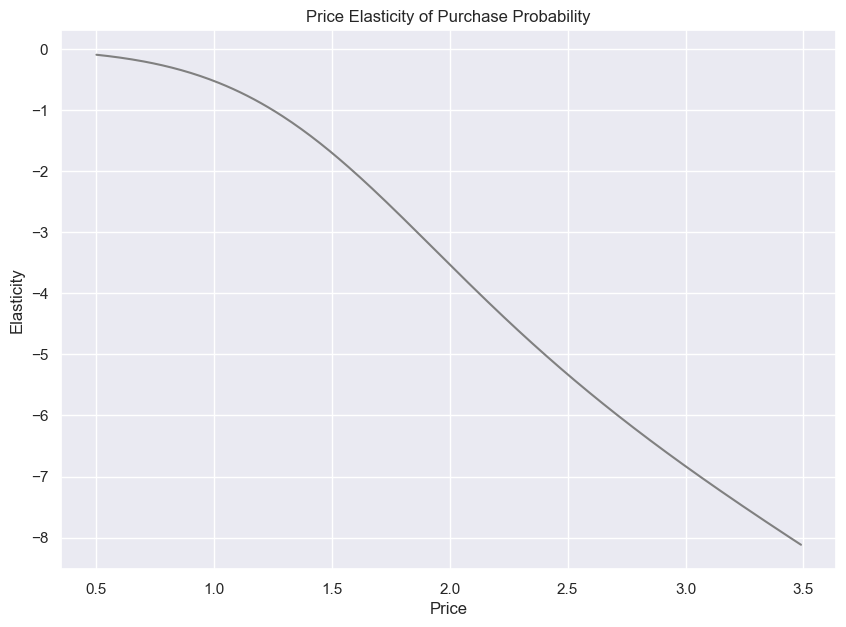

In [14]:
# Displaying the price elasticity of purchase probability of the average customer.
plt.figure(figsize = (10, 7))
plt.plot(price_range, pe, color = 'grey')
plt.xlabel('Price')
plt.ylabel('Elasticity')
plt.title('Price Elasticity of Purchase Probability')

- The decrease in price is slow between the range of 0.5-1.1, Then it becomes steeper after 1.1

- Observing that the price elasticities are all negative. Spots where the customer becomes inelastic are visible.
- The precise spots can be seen in the price elasticities data frame.
- Usually if price values are inelastic the price should increase as it wont cause a big decrease in the output variable.
- If price values are elastic the price should decrease.

- **In conclusion:** With prices lower than 1.25, price can be increased without decreasing purchase probability, but for prices higher than 1.25 prices should be decreased.

## Purchase Probability by Segments

### $\color{green}{\text{Segment 1 - Career-Focused}}$

In [15]:
df_pa_segment_1 = df_pa[df_pa['Segment'] == 1]

In [16]:
Y = df_pa_segment_1['Incidence']

In [17]:
X = pd.DataFrame()

In [18]:
X['Mean_Price'] = (df_pa_segment_1['Price_1'] + 
                   df_pa_segment_1['Price_2'] + 
                   df_pa_segment_1['Price_3'] + 
                   df_pa_segment_1['Price_4'] + 
                   df_pa_segment_1['Price_5']) / 5

In [19]:
model_incidence_segment_1 = LogisticRegression(solver = 'sag')
model_incidence_segment_1.fit(X, Y)

LogisticRegression(solver='sag')

In [20]:
model_incidence_segment_1.coef_

array([[-1.7135925]])

- Observing that the price coefficient for the career focused is -1.7, whereas for the average customer it was -2.35.
- This segment is less price sensitive compared to the average customer.

In [21]:
# Calculating Price Elasticity of the career-focused segment.
Y_segment_1 = model_incidence_segment_1.predict_proba(df_price_range)
purchase_pr_segment_1 = Y_segment_1[:][:, 1]
pe_segment_1 = model_incidence_segment_1.coef_[:, 0] * price_range * (1 - purchase_pr_segment_1)

C:\Users\Muhittin Arslan\anaconda3\lib\site-packages\sklearn\base.py:451: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  "X does not have valid feature names, but"


### Results

In [22]:
df_price_elasticities['PE_Segment_1'] = pe_segment_1
df_price_elasticities

,Price_Point,Mean_PE,PE_Segment_1
0,0.50,-0.096441,-0.119179
1,0.51,-0.100511,-0.123367
2,0.52,-0.104709,-0.127649
3,0.53,-0.109037,-0.132025
4,0.54,-0.113498,-0.136498
5,0.55,-0.118096,-0.141069
6,0.56,-0.122834,-0.145739
7,0.57,-0.127716,-0.150511
8,0.58,-0.132744,-0.155384
9,0.59,-0.137922,-0.160362


Text(0.5, 1.0, 'Price Elasticity of Purchase Probability')

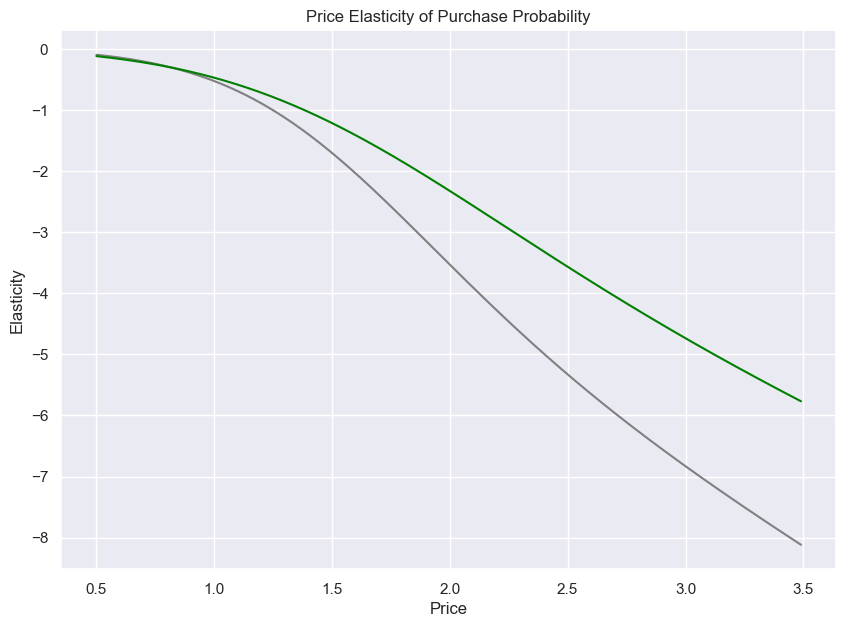

In [23]:
# Plotting the elasticities of the average customer and the career-focused segment side by side. 
# The career-focused segment is displayed in green. The same color that is used in the descriptive analysis notebook.
plt.figure(figsize = (10, 7))
plt.plot(price_range, pe, color = 'grey')
plt.plot(price_range, pe_segment_1, color = 'green')
plt.xlabel('Price')
plt.ylabel('Elasticity')
plt.title('Price Elasticity of Purchase Probability')

### With prices lower than 1.39, price can be increased without decreasing purchase probability, but for prices higher than 1.39 prices should be decreased.

### $\color{red}{\text{Segment 2 - Fewer-Opportunities}}$

In [24]:
df_pa_segment_2 = df_pa[df_pa['Segment'] == 2]

In [25]:
Y = df_pa_segment_2['Incidence']

X = pd.DataFrame()
X['Mean_Price'] = (df_pa_segment_2['Price_1'] + 
                   df_pa_segment_2['Price_2'] + 
                   df_pa_segment_2['Price_3'] + 
                   df_pa_segment_2['Price_4'] + 
                   df_pa_segment_2['Price_5']) / 5

model_incidence_segment2 = LogisticRegression(solver = 'sag')
model_incidence_segment2.fit(X, Y)

model_incidence_segment2.coef_
Y_segment_2 = model_incidence_segment2.predict_proba(df_price_range)
purchase_pr_segment2 = Y_segment_2[:][: , 1]
pe_segment2 = model_incidence_segment2.coef_[:,0] * price_range * ( 1- purchase_pr_segment2)

C:\Users\Muhittin Arslan\anaconda3\lib\site-packages\sklearn\base.py:451: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  "X does not have valid feature names, but"


### Results

In [26]:
df_price_elasticities['PE_Segment_2'] = pe_segment2
df_price_elasticities

,Price_Point,Mean_PE,PE_Segment_1,PE_Segment_2
0,0.50,-0.096441,-0.119179,-0.030914
1,0.51,-0.100511,-0.123367,-0.032681
2,0.52,-0.104709,-0.127649,-0.034534
3,0.53,-0.109037,-0.132025,-0.036479
4,0.54,-0.113498,-0.136498,-0.038518
5,0.55,-0.118096,-0.141069,-0.040657
6,0.56,-0.122834,-0.145739,-0.042899
7,0.57,-0.127716,-0.150511,-0.045249
8,0.58,-0.132744,-0.155384,-0.047711
9,0.59,-0.137922,-0.160362,-0.050292


Text(0.5, 1.0, 'Price Elasticity of Purchase Probability')

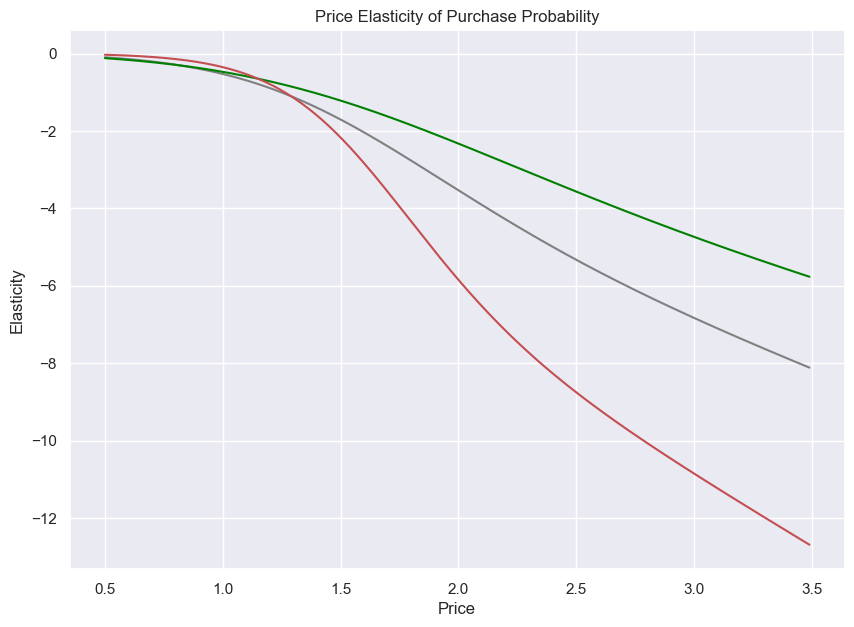

In [27]:
plt.figure(figsize = (10, 7))
plt.plot(price_range, pe, color = 'grey')
plt.plot(price_range, pe_segment_1, color = 'green')
plt.plot(price_range, pe_segment2, color = 'r')
plt.xlabel('Price')
plt.ylabel('Elasticity')
plt.title('Price Elasticity of Purchase Probability')

- The Fewer-Oppurtunities segment is more price sensetive compared to the average and a lot more sensetive compared to Career-Focused segment.
- The line is much steeper than the others. That means with an increase in price they become more and more elastic much faster.

### With prices lower than 1.27, price can be increased without decreasing purchase probability, but for prices higher than 1.27 prices should be decreased.

### $\color{blue}{\text{Segment 0 - Standard}}$

In [28]:
df_pa_segment_0 = df_pa[df_pa['Segment'] == 0]

Y = df_pa_segment_0['Incidence']

X = pd.DataFrame()

X['Mean_Price'] = (df_pa_segment_0['Price_1'] + 
                   df_pa_segment_0['Price_2'] + 
                   df_pa_segment_0['Price_3'] + 
                   df_pa_segment_0['Price_4'] + 
                   df_pa_segment_0['Price_5']) / 5

model_incidence_segment0 = LogisticRegression(solver = 'sag')
model_incidence_segment0.fit(X, Y)

model_incidence_segment0.coef_
Y_segment_0 = model_incidence_segment0.predict_proba(df_price_range)
purchase_pr_segment0 = Y_segment_0[:][: , 1]
pe_segment0 = model_incidence_segment0.coef_[:,0] * price_range *( 1- purchase_pr_segment0)
df_price_elasticities.insert(2, column = 'PE_Segment_0', value = pe_segment0)

C:\Users\Muhittin Arslan\anaconda3\lib\site-packages\sklearn\base.py:451: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  "X does not have valid feature names, but"


In [29]:
df_price_elasticities

,Price_Point,Mean_PE,PE_Segment_0,PE_Segment_1,PE_Segment_2
0,0.50,-0.096441,-0.211280,-0.119179,-0.030914
1,0.51,-0.100511,-0.217854,-0.123367,-0.032681
2,0.52,-0.104709,-0.224536,-0.127649,-0.034534
3,0.53,-0.109037,-0.231326,-0.132025,-0.036479
4,0.54,-0.113498,-0.238225,-0.136498,-0.038518
5,0.55,-0.118096,-0.245235,-0.141069,-0.040657
6,0.56,-0.122834,-0.252355,-0.145739,-0.042899
7,0.57,-0.127716,-0.259587,-0.150511,-0.045249
8,0.58,-0.132744,-0.266931,-0.155384,-0.047711
9,0.59,-0.137922,-0.274388,-0.160362,-0.050292


Text(0.5, 1.0, 'Price Elasticity of Purchase Probability')

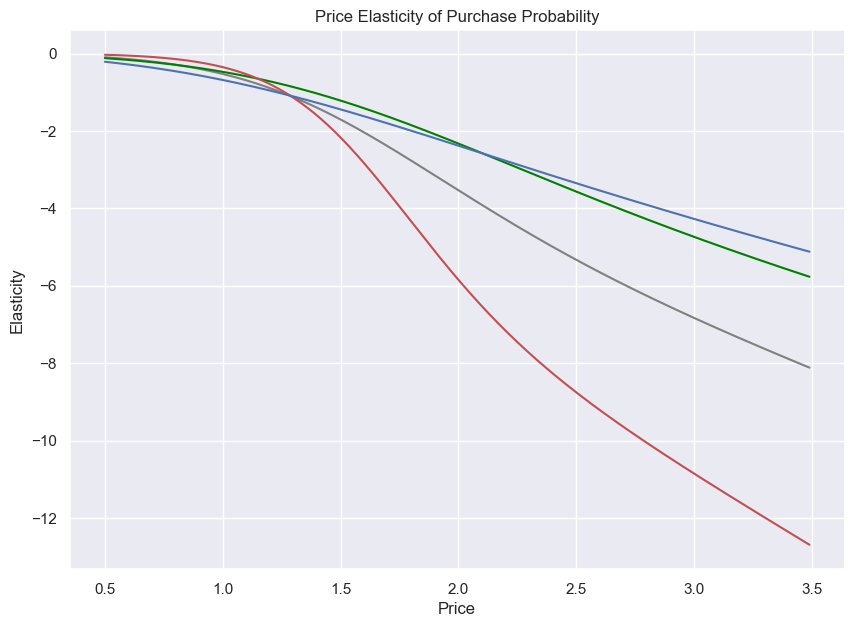

In [30]:
plt.figure(figsize = (10, 7))
plt.plot(price_range, pe, color = 'grey')
plt.plot(price_range, pe_segment_1, color = 'green')
plt.plot(price_range, pe_segment2, color = 'r')
plt.plot(price_range, pe_segment0, color = 'b')
plt.xlabel('Price')
plt.ylabel('Elasticity')
plt.title('Price Elasticity of Purchase Probability')

### With prices lower than 1.23, price can be increased without decreasing purchase probability, but for prices higher than 1.23 prices should be decreased.

### $\color{orange}{\text{Segment 3 - Well-Off}}$

In [31]:
df_pa_segment_3 = df_pa[df_pa['Segment'] == 3]

Y = df_pa_segment_3['Incidence']

X = pd.DataFrame()

X['Mean_Price'] = (df_pa_segment_3['Price_1'] + 
                   df_pa_segment_3['Price_2'] + 
                   df_pa_segment_3['Price_3'] + 
                   df_pa_segment_3['Price_4'] + 
                   df_pa_segment_3['Price_5']) / 5

model_incidence_segment3 = LogisticRegression(solver = 'sag')
model_incidence_segment3.fit(X, Y)

model_incidence_segment3.coef_
Y_segment_3 = model_incidence_segment3.predict_proba(df_price_range)
purchase_pr_segment3 = Y_segment_3[:][: , 1]
pe_segment3 = model_incidence_segment3.coef_[:,0] * price_range *( 1- purchase_pr_segment3)
df_price_elasticities['PE_Segment_3'] = pe_segment3
df_price_elasticities

C:\Users\Muhittin Arslan\anaconda3\lib\site-packages\sklearn\base.py:451: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  "X does not have valid feature names, but"


,Price_Point,Mean_PE,PE_Segment_0,PE_Segment_1,PE_Segment_2,PE_Segment_3
0,0.50,-0.096441,-0.211280,-0.119179,-0.030914,-0.168044
1,0.51,-0.100511,-0.217854,-0.123367,-0.032681,-0.172969
2,0.52,-0.104709,-0.224536,-0.127649,-0.034534,-0.177964
3,0.53,-0.109037,-0.231326,-0.132025,-0.036479,-0.183030
4,0.54,-0.113498,-0.238225,-0.136498,-0.038518,-0.188167
5,0.55,-0.118096,-0.245235,-0.141069,-0.040657,-0.193376
6,0.56,-0.122834,-0.252355,-0.145739,-0.042899,-0.198657
7,0.57,-0.127716,-0.259587,-0.150511,-0.045249,-0.204011
8,0.58,-0.132744,-0.266931,-0.155384,-0.047711,-0.209438
9,0.59,-0.137922,-0.274388,-0.160362,-0.050292,-0.214939


Text(0.5, 1.0, 'Price Elasticity of Purchase Probability')

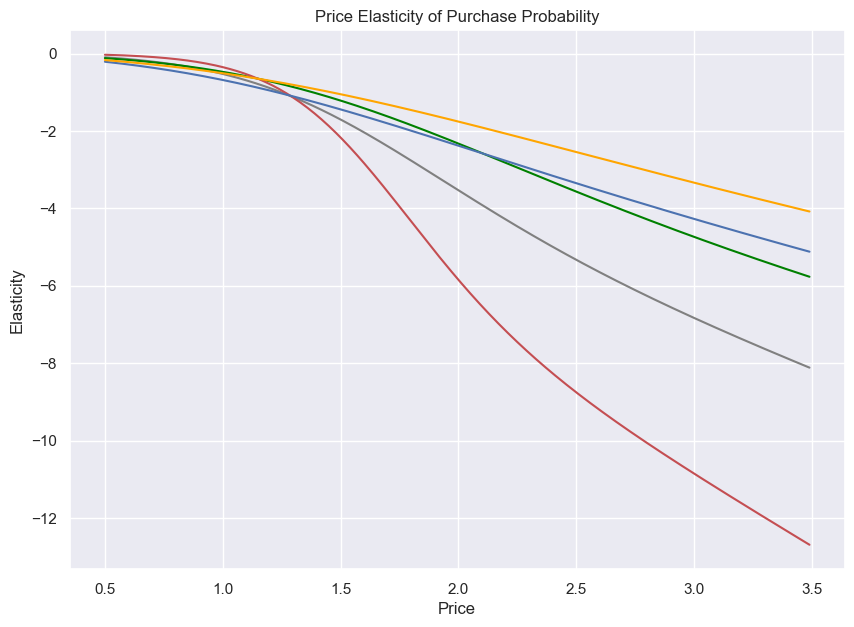

In [32]:
plt.figure(figsize = (10, 7))
plt.plot(price_range, pe, color = 'grey')
plt.plot(price_range, pe_segment_1, color = 'green')
plt.plot(price_range, pe_segment2, color = 'r')
plt.plot(price_range, pe_segment0, color = 'b')
plt.plot(price_range, pe_segment3, color = 'orange')
plt.xlabel('Price')
plt.ylabel('Elasticity')
plt.title('Price Elasticity of Purchase Probability')

### With prices lower than 1.46, price can be increased without decreasing purchase probability, but for prices higher than 1.46 prices should be decreased.

### ${\textbf{Results}}$

Text(0.5, 1.0, 'Price Elasticity of Purchase Probability')

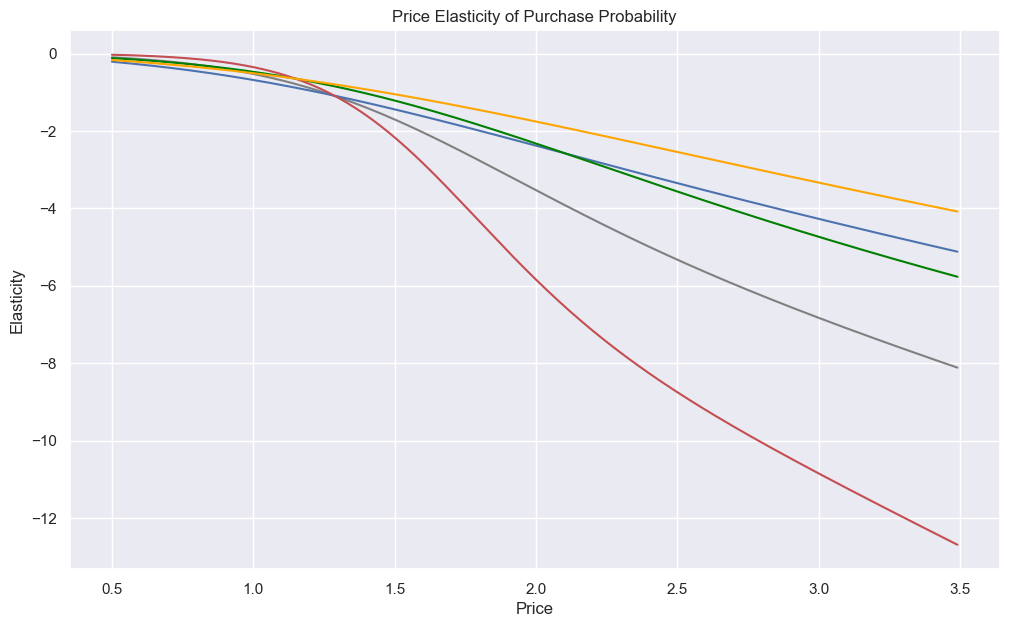

In [33]:
# Displaying all elasticities of purchase probability on the same plot. 
# The Career-focused segment are the least elastic when compared to the rest. 
# So, their purchase probability elasticity is not as affected by price.
# The price elasticities for the Standard segment seem to differ across price range. This may be due to the fact that
# the standard segment is least homogenous, which is discovered during the descriptive analysis phase. 
# It may be that the customers in this segment have different shopping habbits, which is why their 
# customers start with being more elastic than average but then shift to being more inelastic than the average customer
# and indeed the Career-focused segment.
plt.figure(figsize = (12, 7))
plt.plot(price_range, pe, color = 'grey')
plt.plot(price_range, pe_segment0, color = 'b')
plt.plot(price_range, pe_segment_1, color = 'green')
plt.plot(price_range, pe_segment2, color = 'r')
plt.plot(price_range, pe_segment3, color = 'orange')
plt.xlabel('Price')
plt.ylabel('Elasticity')
plt.title('Price Elasticity of Purchase Probability')

## Purchase Probability with Promotion Feature

### Data Preparation

In [34]:
Y = df_pa['Incidence']

In [35]:
X = pd.DataFrame()
X['Mean_Price'] = (df_pa['Price_1'] + 
                   df_pa['Price_2'] + 
                   df_pa['Price_3'] + 
                   df_pa['Price_4'] + 
                   df_pa['Price_5']) / 5

In [36]:
# Including a second promotion feature to examine the effects of promotions on purchase probability.
X['Mean_Promotion'] = (df_pa['Promotion_1'] +
                       df_pa['Promotion_2'] +
                       df_pa['Promotion_3'] +
                       df_pa['Promotion_4'] +
                       df_pa['Promotion_5'] ) / 5
X.head()

,Mean_Price,Mean_Promotion
0,2.044,0.2
1,2.028,0.0
2,2.028,0.0
3,2.028,0.0
4,2.030,0.0


## Model Estimation

In [37]:
model_incidence_promotion = LogisticRegression(solver = 'sag')
model_incidence_promotion.fit(X, Y)
model_incidence_promotion.coef_

array([[-1.49403629,  0.56149589]])

- The coefficient for promotion is positive. 
- Therefore, there is a positive relationship between promotion and purchase probability.

## Price Elasticity with Promotion

In [38]:
df_price_elasticity_promotion = pd.DataFrame(price_range)
df_price_elasticity_promotion = df_price_elasticity_promotion.rename(columns = {0: "Price_Range"})

In [39]:
# Calculating price elasticities of purchase probability assuming there is a promotion across at each price points.
df_price_elasticity_promotion['Promotion'] = 1

In [40]:
# Purchase Probability with Promotion Model Prediction
Y_promotion = model_incidence_promotion.predict_proba(df_price_elasticity_promotion)

C:\Users\Muhittin Arslan\anaconda3\lib\site-packages\sklearn\base.py:493: FutureWarning: The feature names should match those that were passed during fit. Starting version 1.2, an error will be raised.
Feature names unseen at fit time:
- Price_Range
- Promotion
Feature names seen at fit time, yet now missing:
- Mean_Price
- Mean_Promotion

  warnings.warn(message, FutureWarning)


In [41]:
promo = Y_promotion[:, 1]
price_elasticity_promo = (model_incidence_promotion.coef_[:, 0] * price_range) * (1 - promo)

In [42]:
# Updating master dataframe to include elasticities of purchase probability with promotion feature
df_price_elasticities['Elasticity_Promotion_1'] = price_elasticity_promo
df_price_elasticities

,Price_Point,Mean_PE,PE_Segment_0,PE_Segment_1,PE_Segment_2,PE_Segment_3,Elasticity_Promotion_1
0,0.50,-0.096441,-0.211280,-0.119179,-0.030914,-0.168044,-0.125736
1,0.51,-0.100511,-0.217854,-0.123367,-0.032681,-0.172969,-0.129852
2,0.52,-0.104709,-0.224536,-0.127649,-0.034534,-0.177964,-0.134047
3,0.53,-0.109037,-0.231326,-0.132025,-0.036479,-0.183030,-0.138322
4,0.54,-0.113498,-0.238225,-0.136498,-0.038518,-0.188167,-0.142678
5,0.55,-0.118096,-0.245235,-0.141069,-0.040657,-0.193376,-0.147116
6,0.56,-0.122834,-0.252355,-0.145739,-0.042899,-0.198657,-0.151637
7,0.57,-0.127716,-0.259587,-0.150511,-0.045249,-0.204011,-0.156242
8,0.58,-0.132744,-0.266931,-0.155384,-0.047711,-0.209438,-0.160932
9,0.59,-0.137922,-0.274388,-0.160362,-0.050292,-0.214939,-0.165707


## Price Elasticity without Promotion

In [43]:
df_price_elasticity_promotion_no = pd.DataFrame(price_range)
df_price_elasticity_promotion_no = df_price_elasticity_promotion_no.rename(columns = {0: "Price_Range"})

In [44]:
# Promotion feature with No Promotion.
# Assuming there aren't any promotional activities on any of the price points.
df_price_elasticity_promotion_no['Promotion'] = 0

In [45]:
#Purchase Probability without Promotion Model Prediction
Y_no_promo = model_incidence_promotion.predict_proba(df_price_elasticity_promotion_no)

C:\Users\Muhittin Arslan\anaconda3\lib\site-packages\sklearn\base.py:493: FutureWarning: The feature names should match those that were passed during fit. Starting version 1.2, an error will be raised.
Feature names unseen at fit time:
- Price_Range
- Promotion
Feature names seen at fit time, yet now missing:
- Mean_Price
- Mean_Promotion

  warnings.warn(message, FutureWarning)


In [46]:
no_promo = Y_no_promo[: , 1]

In [47]:
price_elasticity_no_promo = model_incidence_promotion.coef_[:, 0] * price_range *(1- no_promo)

In [48]:
# Updating master dataframe to include purchase probability elasticities without promotion.
df_price_elasticities['Elasticity_Promotion_0'] = price_elasticity_no_promo
df_price_elasticities

,Price_Point,Mean_PE,PE_Segment_0,PE_Segment_1,PE_Segment_2,PE_Segment_3,Elasticity_Promotion_1,Elasticity_Promotion_0
0,0.50,-0.096441,-0.211280,-0.119179,-0.030914,-0.168044,-0.125736,-0.195645
1,0.51,-0.100511,-0.217854,-0.123367,-0.032681,-0.172969,-0.129852,-0.201767
2,0.52,-0.104709,-0.224536,-0.127649,-0.034534,-0.177964,-0.134047,-0.207991
3,0.53,-0.109037,-0.231326,-0.132025,-0.036479,-0.183030,-0.138322,-0.214318
4,0.54,-0.113498,-0.238225,-0.136498,-0.038518,-0.188167,-0.142678,-0.220749
5,0.55,-0.118096,-0.245235,-0.141069,-0.040657,-0.193376,-0.147116,-0.227285
6,0.56,-0.122834,-0.252355,-0.145739,-0.042899,-0.198657,-0.151637,-0.233927
7,0.57,-0.127716,-0.259587,-0.150511,-0.045249,-0.204011,-0.156242,-0.240675
8,0.58,-0.132744,-0.266931,-0.155384,-0.047711,-0.209438,-0.160932,-0.247531
9,0.59,-0.137922,-0.274388,-0.160362,-0.050292,-0.214939,-0.165707,-0.254495


Text(0.5, 1.0, 'Price Elasticity of Purchase Probability with and without Promotion')

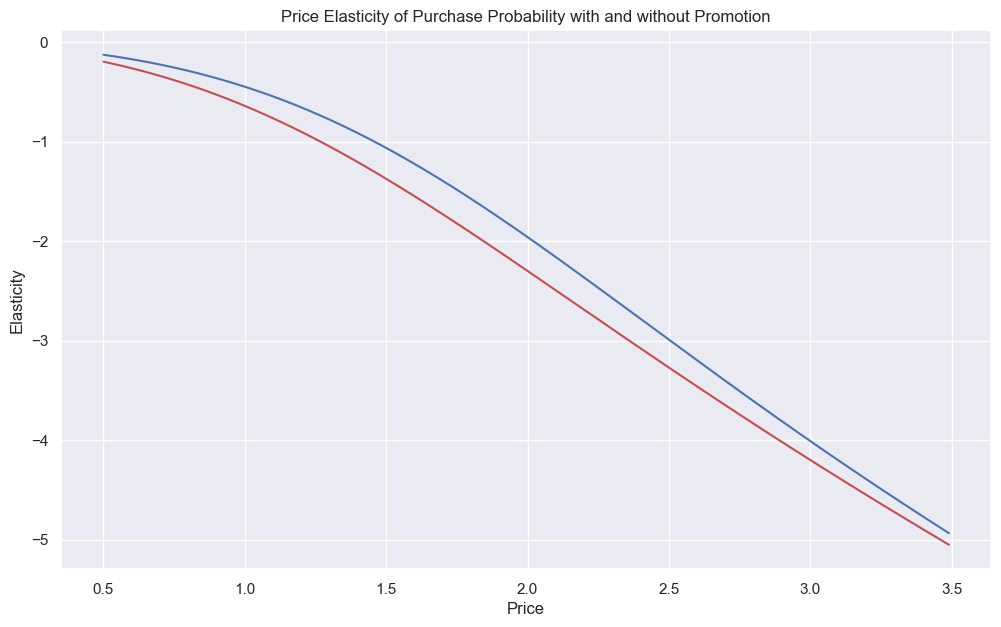

In [49]:
# Plotting purchase elasticities with and without promotion side by side for comprarisson. 
plt.figure(figsize = (12, 7))
plt.plot(price_range, price_elasticity_no_promo, color = 'r')
plt.plot(price_range, price_elasticity_promo, color = 'b')
plt.xlabel('Price')
plt.ylabel('Elasticity')
plt.title('Price Elasticity of Purchase Probability with and without Promotion')

- Observing that the purchase probability elasticity of the customer is less elastic when there is promotion.
- This is an important insight for marketers, as according to our model people are more likely to buy a product if there is some promotional activity rather than purchase a product with the same price, when it isn't on promotion.

## ${\textbf{Brand Choice}}$

### Data Preparation

In [50]:
# Filtering the data to include only purchase occasion, when a purchase has occured. 
brand_choice = df_pa[df_pa['Incidence'] == 1]

In [51]:
pd.options.display.max_rows = 100
brand_choice

,ID,Day,Incidence,Brand,Quantity,Last_Inc_Brand,Last_Inc_Quantity,Price_1,Price_2,Price_3,...,Age,Education,Income,Occupation,Settlement size,Segment,Segment_0,Segment_1,Segment_2,Segment_3
6,200000001,28,1,2,2,0,0,1.50,1.90,1.99,...,47,1,110866,1,0,2,0,0,1,0
11,200000001,58,1,5,1,0,0,1.39,1.90,1.91,...,47,1,110866,1,0,2,0,0,1,0
19,200000001,110,1,1,2,0,0,1.47,1.90,1.99,...,47,1,110866,1,0,2,0,0,1,0
24,200000001,142,1,4,1,0,0,1.21,1.35,1.99,...,47,1,110866,1,0,2,0,0,1,0
29,200000001,183,1,2,3,0,0,1.46,1.88,1.97,...,47,1,110866,1,0,2,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
58621,200000500,296,1,2,6,0,0,1.48,1.89,2.01,...,42,1,120946,1,0,2,0,0,1,0
58648,200000500,460,1,1,12,0,0,1.35,1.57,2.02,...,42,1,120946,1,0,2,0,0,1,0
58674,200000500,641,1,2,7,0,0,1.50,1.85,2.06,...,42,1,120946,1,0,2,0,0,1,0
58687,200000500,697,1,2,6,0,0,1.42,1.51,1.97,...,42,1,120946,1,0,2,0,0,1,0


In [52]:
Y = brand_choice['Brand']

In [53]:
brand_choice.columns.values

array(['ID', 'Day', 'Incidence', 'Brand', 'Quantity', 'Last_Inc_Brand',
       'Last_Inc_Quantity', 'Price_1', 'Price_2', 'Price_3', 'Price_4',
       'Price_5', 'Promotion_1', 'Promotion_2', 'Promotion_3',
       'Promotion_4', 'Promotion_5', 'Sex', 'Marital status', 'Age',
       'Education', 'Income', 'Occupation', 'Settlement size', 'Segment',
       'Segment_0', 'Segment_1', 'Segment_2', 'Segment_3'], dtype=object)

In [54]:
# Predicting based on the prices for the five brands.
features = ['Price_1', 'Price_2', 'Price_3', 'Price_4', 'Price_5']
X = brand_choice[features]

In [55]:
# Brand Choice Model fit.
model_brand_choice = LogisticRegression(solver = 'sag', multi_class = 'multinomial')
model_brand_choice.fit(X, Y)

LogisticRegression(multi_class='multinomial', solver='sag')

In [56]:
model_brand_choice.coef_

array([[-3.91595848,  0.65845929,  2.4177211 ,  0.70408586, -0.20210966],
       [ 1.27461181, -1.87985575, -0.21265049, -0.20634145,  0.58786872],
       [ 1.62419222,  0.56211062,  0.5008998 ,  1.03950847,  0.45279285],
       [ 0.57453542,  0.39558798, -1.40061484, -1.2462446 ,  0.24934901],
       [ 0.44261904,  0.26369787, -1.30535557, -0.29100828, -1.08790092]])

In [57]:
# Creating a pandas data frame, which contains to coefficients.
bc_coef = pd.DataFrame(model_brand_choice.coef_)
bc_coef

,0,1,2,3,4
0,-3.915958,0.658459,2.417721,0.704086,-0.202110
1,1.274612,-1.879856,-0.212650,-0.206341,0.587869
2,1.624192,0.562111,0.500900,1.039508,0.452793
3,0.574535,0.395588,-1.400615,-1.246245,0.249349
4,0.442619,0.263698,-1.305356,-0.291008,-1.087901


In [58]:
# Making transformations on the coefficients data frame to increase readability.
bc_coef = pd.DataFrame(np.transpose(model_brand_choice.coef_))
coefficients = ['Coef_Brand_1', 'Coef_Brand_2', 'Coef_Brand_3', 'Coef_Brand_4', 'Coef_Brand_5']
bc_coef.columns = [coefficients]
prices = ['Price_1', 'Price_2', 'Price_3', 'Price_4', 'Price_5']
bc_coef.index = [prices]
bc_coef = bc_coef.round(2)
bc_coef

,Coef_Brand_1,Coef_Brand_2,Coef_Brand_3,Coef_Brand_4,Coef_Brand_5
Price_1,-3.92,1.27,1.62,0.57,0.44
Price_2,0.66,-1.88,0.56,0.40,0.26
Price_3,2.42,-0.21,0.50,-1.40,-1.31
Price_4,0.70,-0.21,1.04,-1.25,-0.29
Price_5,-0.20,0.59,0.45,0.25,-1.09


## Own Price Elasticity Brand 5

In [59]:
# Calculating price elasticity of brand choice.
df_own_brand_5 = pd.DataFrame(index = np.arange(price_range.size))
df_own_brand_5['Price_1'] = brand_choice['Price_1'].mean()
df_own_brand_5['Price_2'] = brand_choice['Price_2'].mean()
df_own_brand_5['Price_3'] = brand_choice['Price_3'].mean()
df_own_brand_5['Price_4'] = brand_choice['Price_4'].mean()
df_own_brand_5['Price_5'] = price_range
df_own_brand_5

,Price_1,Price_2,Price_3,Price_4,Price_5
0,1.384559,1.764717,2.006694,2.159658,0.50
1,1.384559,1.764717,2.006694,2.159658,0.51
2,1.384559,1.764717,2.006694,2.159658,0.52
3,1.384559,1.764717,2.006694,2.159658,0.53
4,1.384559,1.764717,2.006694,2.159658,0.54
...,...,...,...,...,...
295,1.384559,1.764717,2.006694,2.159658,3.45
296,1.384559,1.764717,2.006694,2.159658,3.46
297,1.384559,1.764717,2.006694,2.159658,3.47
298,1.384559,1.764717,2.006694,2.159658,3.48


In [60]:
predict_brand_5 = model_brand_choice.predict_proba(df_own_brand_5)

In [61]:
# Model returns the probabilities of choosing each of the 5 brands. 
pr_own_brand_5 = predict_brand_5[: ][:, 4]

In [62]:
# The beta coefficient required is that of the brand 5 coefficient and price 5.
beta5 = bc_coef.iloc[4, 4]
beta5

-1.09

In [63]:
# Calculating price elasticities for brand choice without promotion. 
own_price_elasticity_brand_5 = beta5 * price_range * (1 - pr_own_brand_5)

In [64]:
# Adding the price elasticities to the master data frame. 
df_price_elasticities['Brand_5'] = own_price_elasticity_brand_5
pd.options.display.max_rows = None
df_price_elasticities

,Price_Point,Mean_PE,PE_Segment_0,PE_Segment_1,PE_Segment_2,PE_Segment_3,Elasticity_Promotion_1,Elasticity_Promotion_0,Brand_5
0,0.50,-0.096441,-0.211280,-0.119179,-0.030914,-0.168044,-0.125736,-0.195645,-0.049055
1,0.51,-0.100511,-0.217854,-0.123367,-0.032681,-0.172969,-0.129852,-0.201767,-0.050616
2,0.52,-0.104709,-0.224536,-0.127649,-0.034534,-0.177964,-0.134047,-0.207991,-0.052207
3,0.53,-0.109037,-0.231326,-0.132025,-0.036479,-0.183030,-0.138322,-0.214318,-0.053827
4,0.54,-0.113498,-0.238225,-0.136498,-0.038518,-0.188167,-0.142678,-0.220749,-0.055477
5,0.55,-0.118096,-0.245235,-0.141069,-0.040657,-0.193376,-0.147116,-0.227285,-0.057158
6,0.56,-0.122834,-0.252355,-0.145739,-0.042899,-0.198657,-0.151637,-0.233927,-0.058871
7,0.57,-0.127716,-0.259587,-0.150511,-0.045249,-0.204011,-0.156242,-0.240675,-0.060615
8,0.58,-0.132744,-0.266931,-0.155384,-0.047711,-0.209438,-0.160932,-0.247531,-0.062391
9,0.59,-0.137922,-0.274388,-0.160362,-0.050292,-0.214939,-0.165707,-0.254495,-0.064199


Text(0.5, 1.0, 'Own Price Elasticity of Purchase Probability for Brand 5')

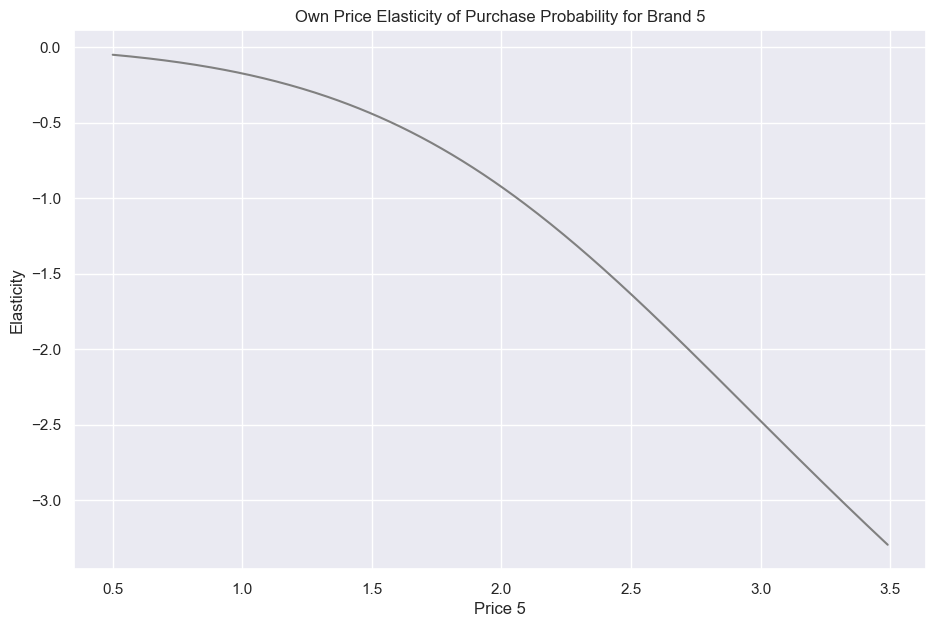

In [65]:
# Plotting elasticities of purchase probability for brand 5.
plt.figure(figsize = (11, 7))
plt.plot(price_range, own_price_elasticity_brand_5, color = 'grey')
plt.xlabel('Price 5')
plt.ylabel('Elasticity')
plt.title('Own Price Elasticity of Purchase Probability for Brand 5')

- What would happen to the purchase probability of brand_5 if a competitor changed their pricing?

## Cross Price Elasticity Brand 5, Cross Brand 4

In [66]:
# Examining the effect of the changes in price of a competitor brand.
# Brand 4 is the closest to brand 5. 
df_brand5_cross_brand4 = pd.DataFrame(index = np.arange(price_range.size))
df_brand5_cross_brand4['Price_1'] = brand_choice['Price_1'].mean()
df_brand5_cross_brand4['Price_2'] = brand_choice['Price_2'].mean()
df_brand5_cross_brand4['Price_3'] = brand_choice['Price_3'].mean()
df_brand5_cross_brand4['Price_4'] = price_range
df_brand5_cross_brand4['Price_5'] = brand_choice['Price_5'].mean()

In [67]:
df_brand5_cross_brand4.head()

,Price_1,Price_2,Price_3,Price_4,Price_5
0,1.384559,1.764717,2.006694,0.50,2.654296
1,1.384559,1.764717,2.006694,0.51,2.654296
2,1.384559,1.764717,2.006694,0.52,2.654296
3,1.384559,1.764717,2.006694,0.53,2.654296
4,1.384559,1.764717,2.006694,0.54,2.654296


In [68]:
predict_brand5_cross_brand4 = model_brand_choice.predict_proba(df_brand5_cross_brand4)

In [69]:
pr_brand_4 = predict_brand5_cross_brand4[:][:, 3]

In [70]:
beta5

-1.09

In [71]:
# The elasticity is equal to negative the price coefficient of the own brand multiplied by the price of the cross brand,
# further multiplied by the probability for choosing the cross brand.
brand5_cross_brand4_price_elasticity = -beta5 * price_range * pr_brand_4

In [72]:
# Updating price elasticities data frame to include the cross price elasticities for brand 5 with respect to brand 4.
df_price_elasticities['Brand_5_Cross_Brand_4'] = brand5_cross_brand4_price_elasticity
df_price_elasticities

,Price_Point,Mean_PE,PE_Segment_0,PE_Segment_1,PE_Segment_2,PE_Segment_3,Elasticity_Promotion_1,Elasticity_Promotion_0,Brand_5,Brand_5_Cross_Brand_4
0,0.50,-0.096441,-0.211280,-0.119179,-0.030914,-0.168044,-0.125736,-0.195645,-0.049055,0.332012
1,0.51,-0.100511,-0.217854,-0.123367,-0.032681,-0.172969,-0.129852,-0.201767,-0.050616,0.337288
2,0.52,-0.104709,-0.224536,-0.127649,-0.034534,-0.177964,-0.134047,-0.207991,-0.052207,0.342507
3,0.53,-0.109037,-0.231326,-0.132025,-0.036479,-0.183030,-0.138322,-0.214318,-0.053827,0.347669
4,0.54,-0.113498,-0.238225,-0.136498,-0.038518,-0.188167,-0.142678,-0.220749,-0.055477,0.352773
5,0.55,-0.118096,-0.245235,-0.141069,-0.040657,-0.193376,-0.147116,-0.227285,-0.057158,0.357820
6,0.56,-0.122834,-0.252355,-0.145739,-0.042899,-0.198657,-0.151637,-0.233927,-0.058871,0.362809
7,0.57,-0.127716,-0.259587,-0.150511,-0.045249,-0.204011,-0.156242,-0.240675,-0.060615,0.367741
8,0.58,-0.132744,-0.266931,-0.155384,-0.047711,-0.209438,-0.160932,-0.247531,-0.062391,0.372614
9,0.59,-0.137922,-0.274388,-0.160362,-0.050292,-0.214939,-0.165707,-0.254495,-0.064199,0.377430


Text(0.5, 1.0, 'Cross Price Elasticity of Brand 5 wrt Brand 4')

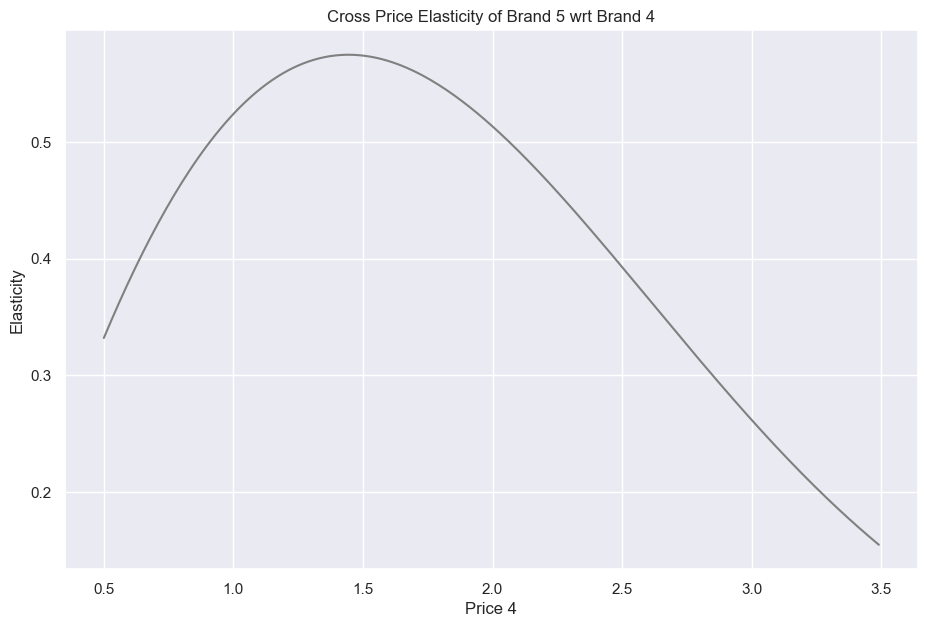

In [73]:
plt.figure(figsize = (11, 7))
plt.plot(price_range, brand5_cross_brand4_price_elasticity, color = 'grey')
plt.xlabel('Price 4')
plt.ylabel('Elasticity')
plt.title('Cross Price Elasticity of Brand 5 wrt Brand 4')

- Observing they are positive. As the price of the competitor brand increases, 
- so does the probability for purchasing the brand 5.
- Even though the elasticity starts to decrease from the 1.45 mark, it is still positive, 
- signalling that the increase in purchase probability for the brand 5 happens more slowly.

## Own and Cross-Price Elasticity by Segment

### $\color{orange}{\text{Well-Off}}$

In [74]:
# Interested in analysing the purchase probability for choosing brand 5 by segments.
# Filtering the data to contain only purchase incidences of the third segment - Well-off.
brand_choice_s3 = df_pa[df_pa['Incidence'] == 1]
brand_choice_s3 = brand_choice_s3[brand_choice_s3['Segment'] == 3]

pd.options.display.max_rows = 100
brand_choice_s3

,ID,Day,Incidence,Brand,Quantity,Last_Inc_Brand,Last_Inc_Quantity,Price_1,Price_2,Price_3,...,Age,Education,Income,Occupation,Settlement size,Segment,Segment_0,Segment_1,Segment_2,Segment_3
101,200000002,6,1,4,1,0,0,1.59,1.87,2.01,...,52,2,159052,2,1,3,0,0,0,1
115,200000002,100,1,4,2,0,0,1.47,1.90,1.95,...,52,2,159052,2,1,3,0,0,0,1
138,200000002,283,1,4,3,0,0,1.37,1.89,2.00,...,52,2,159052,2,1,3,0,0,0,1
141,200000002,307,1,4,1,0,0,1.34,1.89,2.01,...,52,2,159052,2,1,3,0,0,0,1
153,200000002,422,1,4,1,0,0,1.34,1.89,2.02,...,52,2,159052,2,1,3,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
57346,200000489,687,1,4,1,4,1,1.50,1.87,2.06,...,44,2,193816,2,1,3,0,0,0,1
57347,200000489,693,1,4,2,4,1,1.42,1.51,2.02,...,44,2,193816,2,1,3,0,0,0,1
57348,200000489,701,1,4,3,4,1,1.42,1.85,1.99,...,44,2,193816,2,1,3,0,0,0,1
57350,200000489,715,1,4,2,0,0,1.50,1.80,2.09,...,44,2,193816,2,1,3,0,0,0,1


In [75]:
# Brand Choice Model estimation.
Y = brand_choice_s3['Brand']
brand_choice_s3 = pd.get_dummies(brand_choice_s3, columns=['Brand'], prefix = 'Brand', prefix_sep = '_')
X = brand_choice_s3[features]
model_brand_choice_s3 = LogisticRegression(solver = 'sag', multi_class = 'multinomial', max_iter = 300)
model_brand_choice_s3.fit(X, Y)

# Coefficients table for segment 3
bc_coef = pd.DataFrame(np.transpose(model_brand_choice_s3.coef_))
bc_coef.columns = [coefficients]
bc_coef.index = [prices]
bc_coef = bc_coef.round(2)
bc_coef

,Coef_Brand_1,Coef_Brand_2,Coef_Brand_3,Coef_Brand_4,Coef_Brand_5
Price_1,-2.15,1.33,0.82,0.12,-0.11
Price_2,-0.96,-1.38,1.29,0.78,0.27
Price_3,2.01,-1.65,-0.49,0.03,0.11
Price_4,2.52,0.96,-0.25,-1.90,-1.33
Price_5,-0.99,-0.30,1.17,0.56,-0.44


### $\color{orange}{\text{Own-Brand Price Elasticity}}$

In [76]:
# Calculating own-brand price elasticity for brand 5 and the Well-off segment.
df_own_brand_5_s3 = pd.DataFrame(index = np.arange(price_range.size))
df_own_brand_5_s3['Price_1'] = brand_choice_s3['Price_1'].mean()
df_own_brand_5_s3['Price_2'] = brand_choice_s3['Price_2'].mean()
df_own_brand_5_s3['Price_3'] = brand_choice_s3['Price_3'].mean()
df_own_brand_5_s3['Price_4'] = brand_choice_s3['Price_4'].mean()
df_own_brand_5_s3['Price_5'] = price_range

predict_own_brand_5_s3 = model_brand_choice_s3.predict_proba(df_own_brand_5_s3)
pr_own_brand_5_s3 = predict_own_brand_5_s3[: ][: , 4]

own_price_elasticity_brand_5_s3 =  beta5 * price_range * (1 - pr_own_brand_5_s3)
df_price_elasticities['Brand 5 S3'] = own_price_elasticity_brand_5_s3

### $\color{orange}{\text{Cross-Brand Price Elasticity}}$

In [77]:
# Calculating cross-brand price elasticity for brand 5 with respect to brand 4 for the Well-off segment.
df_brand5_cross_brand4_s3 = pd.DataFrame(index = np.arange(price_range.size))
df_brand5_cross_brand4_s3['Price_1'] = brand_choice_s3['Price_1'].mean()
df_brand5_cross_brand4_s3['Price_2'] = brand_choice_s3['Price_2'].mean()
df_brand5_cross_brand4_s3['Price_3'] = brand_choice_s3['Price_3'].mean()
df_brand5_cross_brand4_s3['Price_4'] = price_range
df_brand5_cross_brand4_s3['Price_5'] = brand_choice_s3['Price_5'].mean()

predict_brand5_cross_brand4_s3 = model_brand_choice_s3.predict_proba(df_brand5_cross_brand4_s3)
pr_cross_brand_5_s3 = predict_brand5_cross_brand4_s3[: ][: , 3]

# Updating master dataframe to include the newly obtained cross-brand price elasticities.
brand5_cross_brand4_price_elasticity_s3 = -beta5 * price_range * pr_cross_brand_5_s3
df_price_elasticities['Brand_5_Cross_Brand_4_S3'] = brand5_cross_brand4_price_elasticity_s3
pd.options.display.max_rows = None
df_price_elasticities

,Price_Point,Mean_PE,PE_Segment_0,PE_Segment_1,PE_Segment_2,PE_Segment_3,Elasticity_Promotion_1,Elasticity_Promotion_0,Brand_5,Brand_5_Cross_Brand_4,Brand 5 S3,Brand_5_Cross_Brand_4_S3
0,0.50,-0.096441,-0.211280,-0.119179,-0.030914,-0.168044,-0.125736,-0.195645,-0.049055,0.332012,-0.297345,0.482421
1,0.51,-0.100511,-0.217854,-0.123367,-0.032681,-0.172969,-0.129852,-0.201767,-0.050616,0.337288,-0.303392,0.491727
2,0.52,-0.104709,-0.224536,-0.127649,-0.034534,-0.177964,-0.134047,-0.207991,-0.052207,0.342507,-0.309448,0.501016
3,0.53,-0.109037,-0.231326,-0.132025,-0.036479,-0.183030,-0.138322,-0.214318,-0.053827,0.347669,-0.315515,0.510290
4,0.54,-0.113498,-0.238225,-0.136498,-0.038518,-0.188167,-0.142678,-0.220749,-0.055477,0.352773,-0.321594,0.519548
5,0.55,-0.118096,-0.245235,-0.141069,-0.040657,-0.193376,-0.147116,-0.227285,-0.057158,0.357820,-0.327683,0.528791
6,0.56,-0.122834,-0.252355,-0.145739,-0.042899,-0.198657,-0.151637,-0.233927,-0.058871,0.362809,-0.333785,0.538017
7,0.57,-0.127716,-0.259587,-0.150511,-0.045249,-0.204011,-0.156242,-0.240675,-0.060615,0.367741,-0.339899,0.547227
8,0.58,-0.132744,-0.266931,-0.155384,-0.047711,-0.209438,-0.160932,-0.247531,-0.062391,0.372614,-0.346025,0.556421
9,0.59,-0.137922,-0.274388,-0.160362,-0.050292,-0.214939,-0.165707,-0.254495,-0.064199,0.377430,-0.352165,0.565598


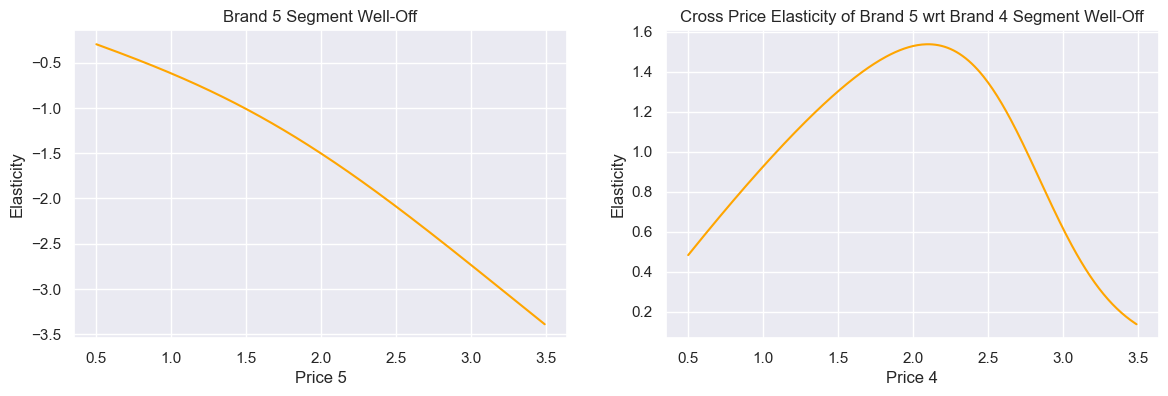

In [82]:
# Using a figure with axes to plot the own brand and cross-brand price elasticities for brand 5 cross brand 4 side by side.
fig, axs = plt.subplots(1, 2, figsize = (14, 4))
axs[0].plot(price_range, own_price_elasticity_brand_5_s3, color = 'orange')
axs[0].set_title('Brand 5 Segment Well-Off')
axs[0].set_xlabel('Price 5')

axs[1].plot(price_range, brand5_cross_brand4_price_elasticity_s3, color = 'orange')
axs[1].set_title('Cross Price Elasticity of Brand 5 wrt Brand 4 Segment Well-Off')
axs[1].set_xlabel('Price 4')

for ax in axs.flat:
    ax.set(ylabel = 'Elasticity')

- The Well-Off customer is elastic to brand_5, that was clear because they choose brand_4 most of the time.
- For the Well-Offs brand 4 is substitute for brand 5.

### $\color{blue}{\text{Standard}}$

In [84]:
brand_choice_s0 = df_pa[df_pa['Incidence'] == 1]
brand_choice_s0 = brand_choice_s0[brand_choice_s0['Segment'] == 0]
brand_choice_s0.head()

,ID,Day,Incidence,Brand,Quantity,Last_Inc_Brand,Last_Inc_Quantity,Price_1,Price_2,Price_3,...,Age,Education,Income,Occupation,Settlement size,Segment,Segment_0,Segment_1,Segment_2,Segment_3
2398,200000024,44,1,2,2,0,0,1.35,1.58,1.97,...,32,1,88428,0,0,0,1,0,0,0
2403,200000024,98,1,2,2,0,0,1.47,1.90,1.95,...,32,1,88428,0,0,0,1,0,0,0
2408,200000024,143,1,2,3,0,0,1.21,1.35,1.99,...,32,1,88428,0,0,0,1,0,0,0
2410,200000024,162,1,2,5,0,0,1.39,1.90,1.94,...,32,1,88428,0,0,0,1,0,0,0
2417,200000024,217,1,5,1,0,0,1.34,1.89,1.99,...,32,1,88428,0,0,0,1,0,0,0


In [85]:
# Brand Choice Model estimation.
Y = brand_choice_s0['Brand']
brand_choice_s0 = pd.get_dummies(brand_choice_s0, columns=['Brand'], prefix = 'Brand', prefix_sep = '_')
X = brand_choice_s0[features]
model_brand_choice_s0 = LogisticRegression(solver = 'sag', multi_class = 'multinomial', max_iter = 200)
model_brand_choice_s0.fit(X, Y)

# Coefficients table segment 0.
bc_coef = pd.DataFrame(np.transpose(model_brand_choice_s0.coef_))
bc_coef.columns = [coefficients]
bc_coef.index = [prices]
bc_coef = bc_coef.round(2)

### $\color{blue}{\text{Own-Brand Price Elasticity}}$

In [86]:
# Calculating own-brand price elasticity for brand 5 and the Standard segment.
df_own_brand_5_s0 = pd.DataFrame(index = np.arange(price_range.size))
df_own_brand_5_s0['Price_1'] = brand_choice_s0['Price_1'].mean()
df_own_brand_5_s0['Price_2'] = brand_choice_s0['Price_2'].mean()
df_own_brand_5_s0['Price_3'] = brand_choice_s0['Price_3'].mean()
df_own_brand_5_s0['Price_4'] = brand_choice_s0['Price_4'].mean()
df_own_brand_5_s0['Price_5'] = price_range

predict_own_brand_5_s0 = model_brand_choice_s0.predict_proba(df_own_brand_5_s0)
pr_own_brand_5_s0 = predict_own_brand_5_s0[: ][: , 4]

# Computing price elasticities and updateing master dataframe.
own_price_elasticity_brand_5_s0 =  beta5 * price_range * (1 - pr_own_brand_5_s0)
df_price_elasticities.insert(10, column = 'Brand 5 S0', value = own_price_elasticity_brand_5_s0)

### $\color{blue}{\text{Cross-Brand Price Elasticity}}$

In [87]:
# Calculating cross-brand price elasticity for brand 5 with respect to brand 4 for the Standard segment.
df_brand5_cross_brand4_s0 = pd.DataFrame(index = np.arange(price_range.size))
df_brand5_cross_brand4_s0['Price_1'] = brand_choice_s0['Price_1'].mean()
df_brand5_cross_brand4_s0['Price_2'] = brand_choice_s0['Price_2'].mean()
df_brand5_cross_brand4_s0['Price_3'] = brand_choice_s0['Price_3'].mean()
df_brand5_cross_brand4_s0['Price_4'] = price_range
df_brand5_cross_brand4_s0['Price_5'] = brand_choice_s0['Price_5'].mean()

predict_brand5_cross_brand4_s0 = model_brand_choice_s0.predict_proba(df_brand5_cross_brand4_s0)
pr_cross_brand_5_s0 = predict_brand5_cross_brand4_s0[: ][: , 3]

# Computing price elasticities and update master dataframe.
brand5_cross_brand4_price_elasticity_s0 = -beta5 * price_range * pr_cross_brand_5_s0
df_price_elasticities.insert(11, column = 'Brand_5_Cross_Brand_4_S0', value = brand5_cross_brand4_price_elasticity_s0)

### $\color{green}{\text{Career-Focused}}$

In [88]:
brand_choice_s1 = df_pa[df_pa['Incidence'] == 1]
brand_choice_s1 = brand_choice_s1[brand_choice_s1['Segment'] == 1]

In [89]:
# Brand Choice Model estimation.
Y = brand_choice_s1['Brand']
brand_choice_s1 = pd.get_dummies(brand_choice_s1, columns=['Brand'], prefix = 'Brand', prefix_sep = '_')
X = brand_choice_s1[features]
model_brand_choice_s1 = LogisticRegression(solver = 'sag', multi_class = 'multinomial', max_iter = 300)
model_brand_choice_s1.fit(X, Y)

# Coefficients table segment 1
bc_coef = pd.DataFrame(np.transpose(model_brand_choice_s1.coef_))
bc_coef.columns = [coefficients]
bc_coef.index = [prices]
bc_coef = bc_coef.round(2)

### $\color{green}{\text{Own-Brand Price Elasticity}}$

In [90]:
# Calculating own-brand price elasticity for brand 5 and the Career-focused segment.
df_own_brand_5_s1 = pd.DataFrame(index = np.arange(price_range.size))
df_own_brand_5_s1['Price_1'] = brand_choice_s1['Price_1'].mean()
df_own_brand_5_s1['Price_2'] = brand_choice_s1['Price_2'].mean()
df_own_brand_5_s1['Price_3'] = brand_choice_s1['Price_3'].mean()
df_own_brand_5_s1['Price_4'] = brand_choice_s1['Price_4'].mean()
df_own_brand_5_s1['Price_5'] = price_range

predict_own_brand_5_s1 = model_brand_choice_s1.predict_proba(df_own_brand_5_s1)
pr_own_brand_5_s1 = predict_own_brand_5_s1[: ][: , 4]

#computing price elasticities and updating dataframe
own_price_elasticity_brand_5_s1 =  beta5 * price_range * (1 - pr_own_brand_5_s1)
df_price_elasticities.insert(12, column = 'Brand 5 S1', value = own_price_elasticity_brand_5_s1)

### $\color{green}{\text{Cross-Brand Price Elasticity}}$

In [91]:
# Calculating cross-brand price elasticity for brand 5 with respect to brand 4 for the Career-focused segment.
df_brand5_cross_brand4_s1 = pd.DataFrame(index = np.arange(price_range.size))
df_brand5_cross_brand4_s1['Price_1'] = brand_choice_s1['Price_1'].mean()
df_brand5_cross_brand4_s1['Price_2'] = brand_choice_s1['Price_2'].mean()
df_brand5_cross_brand4_s1['Price_3'] = brand_choice_s1['Price_3'].mean()
df_brand5_cross_brand4_s1['Price_4'] = price_range
df_brand5_cross_brand4_s1['Price_5'] = brand_choice_s1['Price_5'].mean()

predict_brand5_cross_brand4_s1 = model_brand_choice_s1.predict_proba(df_brand5_cross_brand4_s1)
pr_cross_brand_5_s1 = predict_brand5_cross_brand4_s1[: ][: , 3]

brand5_cross_brand4_price_elasticity_s1 = -beta5 * price_range * pr_cross_brand_5_s1
df_price_elasticities.insert(13, column = 'Brand_5_Cross_Brand_4_S1', value = brand5_cross_brand4_price_elasticity_s1)

### $\color{red}{\text{Fewer-Opportunities}}$

In [92]:
brand_choice_s2 = df_pa[df_pa['Incidence'] == 1]
brand_choice_s2 = brand_choice_s2[brand_choice_s2['Segment'] == 2]

In [93]:
# Brand Choice Model estimation.
Y = brand_choice_s2['Brand']
brand_choice_s2 = pd.get_dummies(brand_choice_s2, columns=['Brand'], prefix = 'Brand', prefix_sep = '_')
X = brand_choice_s2[features]
model_brand_choice_s2 = LogisticRegression(solver = 'sag', multi_class = 'multinomial', max_iter = 300)
model_brand_choice_s2.fit(X, Y)

# Coefficients table segment 2
bc_coef = pd.DataFrame(np.transpose(model_brand_choice_s2.coef_))
bc_coef.columns = [coefficients]
bc_coef.index = [prices]
bc_coef = bc_coef.round(2)

### $\color{red}{\text{Own-Brand Price Elasticity}}$

In [94]:
# Calculating own-brand price elasticity for brand 5 and the Fewer-opportunities segment.
df_own_brand_5_s2 = pd.DataFrame(index = np.arange(price_range.size))
df_own_brand_5_s2['Price_1'] = brand_choice_s2['Price_1'].mean()
df_own_brand_5_s2['Price_2'] = brand_choice_s2['Price_2'].mean()
df_own_brand_5_s2['Price_3'] = brand_choice_s2['Price_3'].mean()
df_own_brand_5_s2['Price_4'] = brand_choice_s2['Price_4'].mean()
df_own_brand_5_s2['Price_5'] = price_range

predict_own_brand_5_s2 = model_brand_choice_s2.predict_proba(df_own_brand_5_s2)
pr_own_brand_5_s2 = predict_own_brand_5_s2[: ][: , 4]

#computing price elasticities and updating dataframe
own_price_elasticity_brand_5_s2 =  beta5 * price_range * (1 - pr_own_brand_5_s2)
df_price_elasticities.insert(14, column = 'Brand 5 S2', value = own_price_elasticity_brand_5_s2)

### $\color{red}{\text{Cross-Brand Price Elasticity}}$

In [95]:
# Calculating cross-brand price elasticity for brand 5 with respect to brand 4 for the Fewer-opportunities segment.
df_brand5_cross_brand4_s2 = pd.DataFrame(index = np.arange(price_range.size))
df_brand5_cross_brand4_s2['Price_1'] = brand_choice_s2['Price_1'].mean()
df_brand5_cross_brand4_s2['Price_2'] = brand_choice_s2['Price_2'].mean()
df_brand5_cross_brand4_s2['Price_3'] = brand_choice_s2['Price_3'].mean()
df_brand5_cross_brand4_s2['Price_4'] = price_range
df_brand5_cross_brand4_s2['Price_5'] = brand_choice_s2['Price_5'].mean()

predict_brand5_cross_brand4_s2 = model_brand_choice_s2.predict_proba(df_brand5_cross_brand4_s2)
pr_cross_brand_5_s2 = predict_brand5_cross_brand4_s2[: ][: , 3]

brand5_cross_brand4_price_elasticity_s2 = -beta5 * price_range * pr_cross_brand_5_s2
df_price_elasticities.insert(15, column = 'Brand_5_Cross_Brand_4_S2', value = brand5_cross_brand4_price_elasticity_s2)
df_price_elasticities

,Price_Point,Mean_PE,PE_Segment_0,PE_Segment_1,PE_Segment_2,PE_Segment_3,Elasticity_Promotion_1,Elasticity_Promotion_0,Brand_5,Brand_5_Cross_Brand_4,Brand 5 S0,Brand_5_Cross_Brand_4_S0,Brand 5 S1,Brand_5_Cross_Brand_4_S1,Brand 5 S2,Brand_5_Cross_Brand_4_S2,Brand 5 S3,Brand_5_Cross_Brand_4_S3
0,0.50,-0.096441,-0.211280,-0.119179,-0.030914,-0.168044,-0.125736,-0.195645,-0.049055,0.332012,-0.115818,0.174079,-0.043942,0.194763,-0.001036,0.181598,-0.297345,0.482421
1,0.51,-0.100511,-0.217854,-0.123367,-0.032681,-0.172969,-0.129852,-0.201767,-0.050616,0.337288,-0.118857,0.176135,-0.045029,0.197247,-0.001098,0.183895,-0.303392,0.491727
2,0.52,-0.104709,-0.224536,-0.127649,-0.034534,-0.177964,-0.134047,-0.207991,-0.052207,0.342507,-0.121930,0.178139,-0.046125,0.199680,-0.001163,0.186143,-0.309448,0.501016
3,0.53,-0.109037,-0.231326,-0.132025,-0.036479,-0.183030,-0.138322,-0.214318,-0.053827,0.347669,-0.125039,0.180092,-0.047230,0.202062,-0.001231,0.188343,-0.315515,0.510290
4,0.54,-0.113498,-0.238225,-0.136498,-0.038518,-0.188167,-0.142678,-0.220749,-0.055477,0.352773,-0.128184,0.181995,-0.048345,0.204394,-0.001303,0.190494,-0.321594,0.519548
5,0.55,-0.118096,-0.245235,-0.141069,-0.040657,-0.193376,-0.147116,-0.227285,-0.057158,0.357820,-0.131364,0.183849,-0.049469,0.206676,-0.001378,0.192596,-0.327683,0.528791
6,0.56,-0.122834,-0.252355,-0.145739,-0.042899,-0.198657,-0.151637,-0.233927,-0.058871,0.362809,-0.134582,0.185652,-0.050603,0.208908,-0.001458,0.194651,-0.333785,0.538017
7,0.57,-0.127716,-0.259587,-0.150511,-0.045249,-0.204011,-0.156242,-0.240675,-0.060615,0.367741,-0.137836,0.187406,-0.051747,0.211092,-0.001541,0.196659,-0.339899,0.547227
8,0.58,-0.132744,-0.266931,-0.155384,-0.047711,-0.209438,-0.160932,-0.247531,-0.062391,0.372614,-0.141128,0.189111,-0.052900,0.213226,-0.001629,0.198618,-0.346025,0.556421
9,0.59,-0.137922,-0.274388,-0.160362,-0.050292,-0.214939,-0.165707,-0.254495,-0.064199,0.377430,-0.144457,0.190768,-0.054064,0.215311,-0.001722,0.200531,-0.352165,0.565598


Text(0.5, 0, 'Price 4')

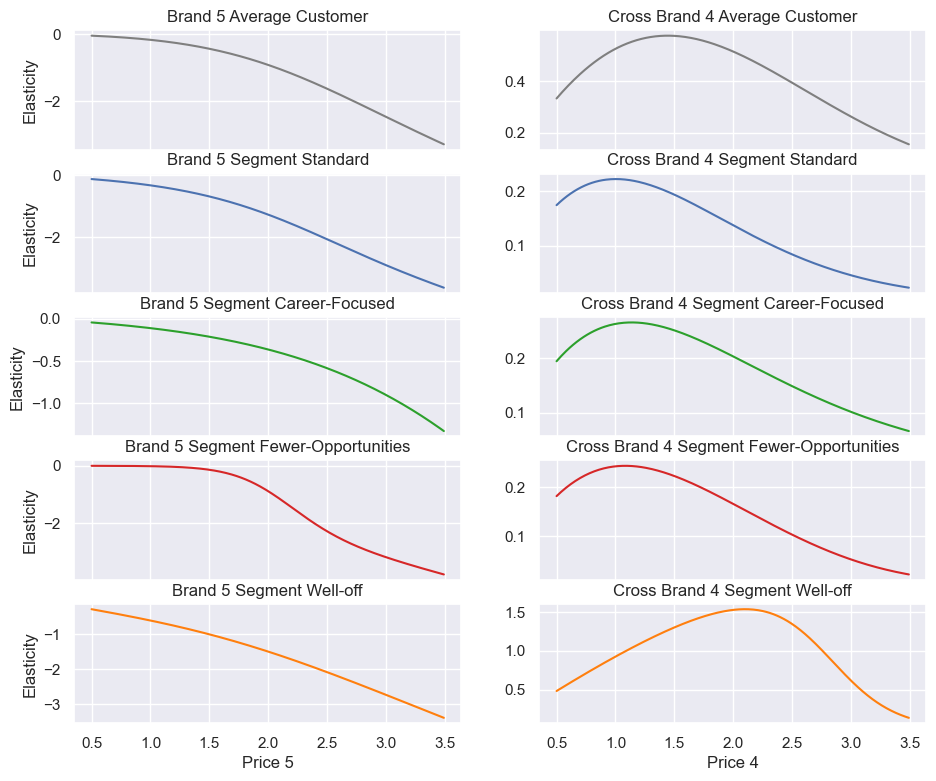

In [96]:
# Plotting the own and cross brand price elasticities for the average customer and each of the four segments.
fig1, (ax1, ax2, ax3, ax4, ax5) = plt.subplots(5, 2, figsize = (11, 9), sharex = True)
ax1[0].plot(price_range, own_price_elasticity_brand_5, 'tab:grey')
ax1[0].set_title('Brand 5 Average Customer')
ax1[0].set_ylabel('Elasticity')
ax1[1].plot(price_range, brand5_cross_brand4_price_elasticity, 'tab:grey')
ax1[1].set_title('Cross Brand 4 Average Customer')


ax2[0].plot(price_range, own_price_elasticity_brand_5_s0)
ax2[0].set_title('Brand 5 Segment Standard')
ax2[0].set_ylabel('Elasticity')
ax2[1].plot(price_range, brand5_cross_brand4_price_elasticity_s0)
ax2[1].set_title('Cross Brand 4 Segment Standard')

ax3[0].plot(price_range, own_price_elasticity_brand_5_s1, 'tab:green')
ax3[0].set_title('Brand 5 Segment Career-Focused')
ax3[0].set_ylabel('Elasticity')
ax3[1].plot(price_range, brand5_cross_brand4_price_elasticity_s1, 'tab:green')
ax3[1].set_title('Cross Brand 4 Segment Career-Focused')

ax4[0].plot(price_range, own_price_elasticity_brand_5_s2, 'tab:red')
ax4[0].set_title('Brand 5 Segment Fewer-Opportunities')
ax4[0].set_ylabel('Elasticity')
ax4[1].plot(price_range, brand5_cross_brand4_price_elasticity_s2, 'tab:red')
ax4[1].set_title('Cross Brand 4 Segment Fewer-Opportunities')

ax5[0].plot(price_range, own_price_elasticity_brand_5_s3, 'tab:orange')
ax5[0].set_title('Brand 5 Segment Well-off')
ax5[0].set_xlabel('Price 5')
ax5[0].set_ylabel('Elasticity')
ax5[1].plot(price_range, brand5_cross_brand4_price_elasticity_s3, 'tab:orange')
ax5[1].set_title('Cross Brand 4 Segment Well-off')
ax5[1].set_xlabel('Price 4')

- Differences and similiraties can be seen between the segments and examine their preference, when it comes to brand choice.
- The two segments, which seem to be of most interested for the marketing team of brand 5, seem to be the Career-focused
- and the Well-off. They are also the segments which purchase this brand most often. 
- The Career-focused segment is the most inelastic and they are the most loyal segment. 
- Based on the model, they do not seem to be that affected by price, therefore brand 5 could increase its price, 
- without fear of significant loss of customers from this segment. 
- The Well-off segment on the other hand, seems to be more elastic. They also purchase the competitor brand 4 most often.
- In order to target this segment, the analysis signals, that price needs to be decreased. However, 
- that other factors aside from price might be influencing the purchase behaivour of this segment.

## Price Elasticity of Purchase Quantity

In [97]:
# Determining price elasticity of purchase quantity, also known as price elasticity of demand.
# Filtering the data to contain only shopping visits where the client has purchased at least one product.
df_purchase_quantity = df_pa[df_pa['Incidence'] == 1]
df_purchase_quantity.head()

,ID,Day,Incidence,Brand,Quantity,Last_Inc_Brand,Last_Inc_Quantity,Price_1,Price_2,Price_3,...,Age,Education,Income,Occupation,Settlement size,Segment,Segment_0,Segment_1,Segment_2,Segment_3
6,200000001,28,1,2,2,0,0,1.50,1.90,1.99,...,47,1,110866,1,0,2,0,0,1,0
11,200000001,58,1,5,1,0,0,1.39,1.90,1.91,...,47,1,110866,1,0,2,0,0,1,0
19,200000001,110,1,1,2,0,0,1.47,1.90,1.99,...,47,1,110866,1,0,2,0,0,1,0
24,200000001,142,1,4,1,0,0,1.21,1.35,1.99,...,47,1,110866,1,0,2,0,0,1,0
29,200000001,183,1,2,3,0,0,1.46,1.88,1.97,...,47,1,110866,1,0,2,0,0,1,0


In [98]:
# Creating brand dummies, for each of the five brands.
df_purchase_quantity = pd.get_dummies(df_purchase_quantity, columns = ['Brand'], prefix = 'Brand', prefix_sep = '_')
# The descriptive analysis of the purchase quantitiy dataframe, shows that quantity ranges from 1 to 15 
# and has an average value of 2.8, which means that more often than not our customers buy more than 1 chocolate candy bar.
df_purchase_quantity.describe()

,ID,Day,Incidence,Quantity,Last_Inc_Brand,Last_Inc_Quantity,Price_1,Price_2,Price_3,Price_4,...,Segment,Segment_0,Segment_1,Segment_2,Segment_3,Brand_1,Brand_2,Brand_3,Brand_4,Brand_5
count,1.463800e+04,14638.000000,14638.0,14638.000000,14638.000000,14638.000000,14638.000000,14638.000000,14638.000000,14638.000000,...,14638.000000,14638.000000,14638.000000,14638.000000,14638.000000,14638.000000,14638.000000,14638.000000,14638.000000,14638.000000
mean,2.000003e+08,359.607597,1.0,2.774559,1.535251,0.406955,1.384559,1.764717,2.006694,2.159658,...,1.581910,0.175229,0.299290,0.293824,0.231657,0.092226,0.310288,0.057453,0.199959,0.340074
std,1.423786e+02,205.346253,0.0,1.796736,2.060858,0.491283,0.090944,0.181667,0.046200,0.093253,...,1.028171,0.380176,0.457962,0.455528,0.421906,0.289354,0.462627,0.232714,0.399983,0.473750
min,2.000000e+08,1.000000,1.0,1.000000,0.000000,0.000000,1.100000,1.260000,1.870000,1.760000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,2.000001e+08,175.000000,1.0,2.000000,0.000000,0.000000,1.340000,1.570000,1.970000,2.120000,...,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,2.000003e+08,355.000000,1.0,2.000000,0.000000,0.000000,1.390000,1.880000,2.010000,2.180000,...,2.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,2.000004e+08,532.000000,1.0,3.000000,4.000000,1.000000,1.470000,1.890000,2.060000,2.240000,...,2.000000,0.000000,1.000000,1.000000,0.000000,0.000000,1.000000,0.000000,0.000000,1.000000
max,2.000005e+08,727.000000,1.0,15.000000,5.000000,1.000000,1.590000,1.900000,2.140000,2.260000,...,3.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [99]:
df_purchase_quantity.columns.values

array(['ID', 'Day', 'Incidence', 'Quantity', 'Last_Inc_Brand',
       'Last_Inc_Quantity', 'Price_1', 'Price_2', 'Price_3', 'Price_4',
       'Price_5', 'Promotion_1', 'Promotion_2', 'Promotion_3',
       'Promotion_4', 'Promotion_5', 'Sex', 'Marital status', 'Age',
       'Education', 'Income', 'Occupation', 'Settlement size', 'Segment',
       'Segment_0', 'Segment_1', 'Segment_2', 'Segment_3', 'Brand_1',
       'Brand_2', 'Brand_3', 'Brand_4', 'Brand_5'], dtype=object)

In [100]:
# Finding the price of the product that is chosen at this incidence
df_purchase_quantity['Price_Incidence'] = (df_purchase_quantity['Brand_1'] * df_purchase_quantity['Price_1'] +
                                           df_purchase_quantity['Brand_2'] * df_purchase_quantity['Price_2'] +
                                           df_purchase_quantity['Brand_3'] * df_purchase_quantity['Price_3'] +
                                           df_purchase_quantity['Brand_4'] * df_purchase_quantity['Price_4'] +
                                           df_purchase_quantity['Brand_5'] * df_purchase_quantity['Price_5'] )

In [101]:
# Finding the price of the product that is chosen at this incidence
df_purchase_quantity['Promotion_Incidence'] = (df_purchase_quantity['Brand_1'] * df_purchase_quantity['Promotion_1'] +
                                               df_purchase_quantity['Brand_2'] * df_purchase_quantity['Promotion_2'] +
                                               df_purchase_quantity['Brand_3'] * df_purchase_quantity['Promotion_3'] +
                                               df_purchase_quantity['Brand_4'] * df_purchase_quantity['Promotion_4'] +
                                               df_purchase_quantity['Brand_5'] * df_purchase_quantity['Promotion_5'] )

## Model Estimation. Linear Regression

In [102]:
X = df_purchase_quantity[['Price_Incidence', 'Promotion_Incidence']]
pd.options.display.max_rows = 100
X

,Price_Incidence,Promotion_Incidence
6,1.90,0
11,2.62,1
19,1.47,0
24,2.16,0
29,1.88,0
...,...,...
58621,1.89,0
58648,1.35,1
58674,1.85,1
58687,1.51,0


In [103]:
Y = df_purchase_quantity['Quantity']
Y.head()

6     2
11    1
19    2
24    1
29    3
Name: Quantity, dtype: int64

In [104]:
# Linear Regression Model
model_quantity = LinearRegression()
model_quantity.fit(X, Y)

LinearRegression()

In [105]:
model_quantity.coef_

array([-0.8173651 , -0.10504673])

- Linear Regression Model. The coefficients for price and promotion are both negative. 
- It appears that promotion reflects negatively on the purchase quantity of the average client, which is unexpected,
- maybe some important information is missing in our dataset,
- or maybe promotion is prompting a customer to try out a new brand

## Price Elasticity with Promotion

In [106]:
# Examining the price elasticity of purchase quantity with active promotional activities for each price point.
df_price_elasticity_quantity = pd.DataFrame(index = np.arange(price_range.size))
df_price_elasticity_quantity['Price_Incidence'] = price_range
df_price_elasticity_quantity['Promotion_Incidence'] = 1

In [107]:
beta_quantity = model_quantity.coef_[0]
beta_quantity

-0.8173651016684998

In [108]:
predict_quantity = model_quantity.predict(df_price_elasticity_quantity)

In [109]:
# Calculating the price elasticity with our new formula. It is the beta coefficient for price multiplied by price
# and divided by the purchase quantity.
price_elasticity_quantity_promotion_yes = beta_quantity * price_range / predict_quantity

In [110]:
df_price_elasticities['PE_Quantity_Promotion_1'] = price_elasticity_quantity_promotion_yes
df_price_elasticities

,Price_Point,Mean_PE,PE_Segment_0,PE_Segment_1,PE_Segment_2,PE_Segment_3,Elasticity_Promotion_1,Elasticity_Promotion_0,Brand_5,Brand_5_Cross_Brand_4,Brand 5 S0,Brand_5_Cross_Brand_4_S0,Brand 5 S1,Brand_5_Cross_Brand_4_S1,Brand 5 S2,Brand_5_Cross_Brand_4_S2,Brand 5 S3,Brand_5_Cross_Brand_4_S3,PE_Quantity_Promotion_1
0,0.50,-0.096441,-0.211280,-0.119179,-0.030914,-0.168044,-0.125736,-0.195645,-0.049055,0.332012,-0.115818,0.174079,-0.043942,0.194763,-0.001036,0.181598,-0.297345,0.482421,-0.102157
1,0.51,-0.100511,-0.217854,-0.123367,-0.032681,-0.172969,-0.129852,-0.201767,-0.050616,0.337288,-0.118857,0.176135,-0.045029,0.197247,-0.001098,0.183895,-0.303392,0.491727,-0.104413
2,0.52,-0.104709,-0.224536,-0.127649,-0.034534,-0.177964,-0.134047,-0.207991,-0.052207,0.342507,-0.121930,0.178139,-0.046125,0.199680,-0.001163,0.186143,-0.309448,0.501016,-0.106679
3,0.53,-0.109037,-0.231326,-0.132025,-0.036479,-0.183030,-0.138322,-0.214318,-0.053827,0.347669,-0.125039,0.180092,-0.047230,0.202062,-0.001231,0.188343,-0.315515,0.510290,-0.108954
4,0.54,-0.113498,-0.238225,-0.136498,-0.038518,-0.188167,-0.142678,-0.220749,-0.055477,0.352773,-0.128184,0.181995,-0.048345,0.204394,-0.001303,0.190494,-0.321594,0.519548,-0.111238
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
295,3.45,-8.015588,-5.052819,-5.687430,-12.545700,-4.022039,-4.861671,-4.983275,-3.231573,0.162234,-3.592451,0.024060,-1.287426,0.068596,-3.746081,0.023406,-3.337316,0.157509,-1.774292
296,3.46,-8.040842,-5.069676,-5.707597,-12.582627,-4.036906,-4.879873,-5.000181,-3.247767,0.160334,-3.606355,0.023704,-1.297235,0.067973,-3.757523,0.022946,-3.350646,0.152087,-1.788634
297,3.47,-8.066062,-5.086515,-5.727728,-12.619537,-4.051757,-4.898044,-5.017067,-3.263928,0.158448,-3.620215,0.023352,-1.307100,0.067354,-3.768945,0.022493,-3.363973,0.146830,-1.803124
298,3.48,-8.091248,-5.103335,-5.747822,-12.656431,-4.066592,-4.916185,-5.033934,-3.280058,0.156577,-3.634032,0.023005,-1.317019,0.066740,-3.780347,0.022048,-3.377297,0.141734,-1.817766


Text(0.5, 1.0, 'Price Elasticity of Purchase Quantity with Promotion')

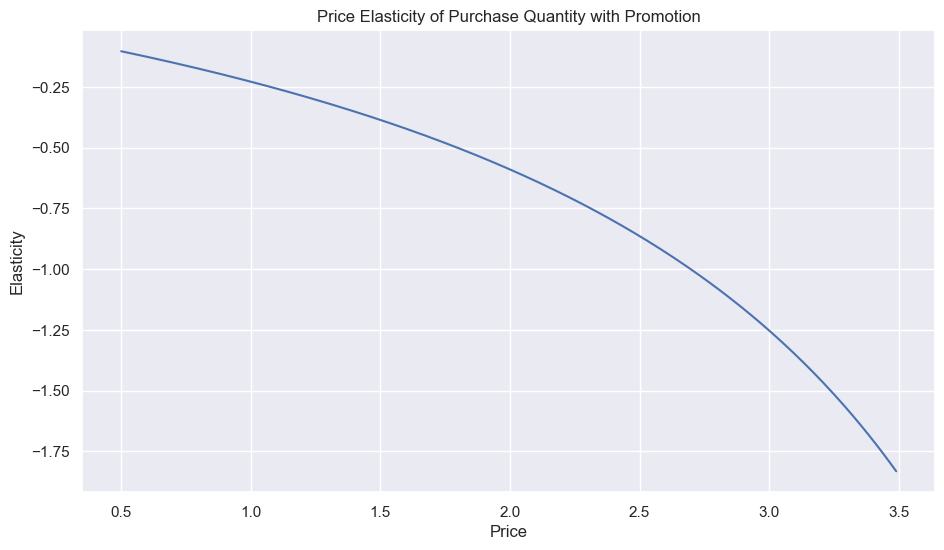

In [112]:
plt.figure(figsize = (11, 6))
plt.plot(price_range, price_elasticity_quantity_promotion_yes)
plt.xlabel('Price')
plt.ylabel('Elasticity')
plt.title('Price Elasticity of Purchase Quantity with Promotion')

## Price Elasticity without Promotion

In [114]:
# Overwriting promotion incidence in order to use the same df. 
# Assuming there are no promotinal activities active for the entire price range.
df_price_elasticity_quantity['Promotion_Incidence'] = 0

predict_quantity = model_quantity.predict(df_price_elasticity_quantity)

price_elasticity_quantity_promotion_no = beta_quantity * price_range / predict_quantity

df_price_elasticities['PE_Quantity_Promotion_0'] = price_elasticity_quantity_promotion_no
df_price_elasticities

,Price_Point,Mean_PE,PE_Segment_0,PE_Segment_1,PE_Segment_2,PE_Segment_3,Elasticity_Promotion_1,Elasticity_Promotion_0,Brand_5,Brand_5_Cross_Brand_4,Brand 5 S0,Brand_5_Cross_Brand_4_S0,Brand 5 S1,Brand_5_Cross_Brand_4_S1,Brand 5 S2,Brand_5_Cross_Brand_4_S2,Brand 5 S3,Brand_5_Cross_Brand_4_S3,PE_Quantity_Promotion_1,PE_Quantity_Promotion_0
0,0.50,-0.096441,-0.211280,-0.119179,-0.030914,-0.168044,-0.125736,-0.195645,-0.049055,0.332012,-0.115818,0.174079,-0.043942,0.194763,-0.001036,0.181598,-0.297345,0.482421,-0.102157,-0.099543
1,0.51,-0.100511,-0.217854,-0.123367,-0.032681,-0.172969,-0.129852,-0.201767,-0.050616,0.337288,-0.118857,0.176135,-0.045029,0.197247,-0.001098,0.183895,-0.303392,0.491727,-0.104413,-0.101736
2,0.52,-0.104709,-0.224536,-0.127649,-0.034534,-0.177964,-0.134047,-0.207991,-0.052207,0.342507,-0.121930,0.178139,-0.046125,0.199680,-0.001163,0.186143,-0.309448,0.501016,-0.106679,-0.103939
3,0.53,-0.109037,-0.231326,-0.132025,-0.036479,-0.183030,-0.138322,-0.214318,-0.053827,0.347669,-0.125039,0.180092,-0.047230,0.202062,-0.001231,0.188343,-0.315515,0.510290,-0.108954,-0.106150
4,0.54,-0.113498,-0.238225,-0.136498,-0.038518,-0.188167,-0.142678,-0.220749,-0.055477,0.352773,-0.128184,0.181995,-0.048345,0.204394,-0.001303,0.190494,-0.321594,0.519548,-0.111238,-0.108369
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
295,3.45,-8.015588,-5.052819,-5.687430,-12.545700,-4.022039,-4.861671,-4.983275,-3.231573,0.162234,-3.592451,0.024060,-1.287426,0.068596,-3.746081,0.023406,-3.337316,0.157509,-1.774292,-1.664290
296,3.46,-8.040842,-5.069676,-5.707597,-12.582627,-4.036906,-4.879873,-5.000181,-3.247767,0.160334,-3.606355,0.023704,-1.297235,0.067973,-3.757523,0.022946,-3.350646,0.152087,-1.788634,-1.677205
297,3.47,-8.066062,-5.086515,-5.727728,-12.619537,-4.051757,-4.898044,-5.017067,-3.263928,0.158448,-3.620215,0.023352,-1.307100,0.067354,-3.768945,0.022493,-3.363973,0.146830,-1.803124,-1.690246
298,3.48,-8.091248,-5.103335,-5.747822,-12.656431,-4.066592,-4.916185,-5.033934,-3.280058,0.156577,-3.634032,0.023005,-1.317019,0.066740,-3.780347,0.022048,-3.377297,0.141734,-1.817766,-1.703414


Text(0.5, 1.0, 'Price Elasticity of Purchase Quantity with Promotion')

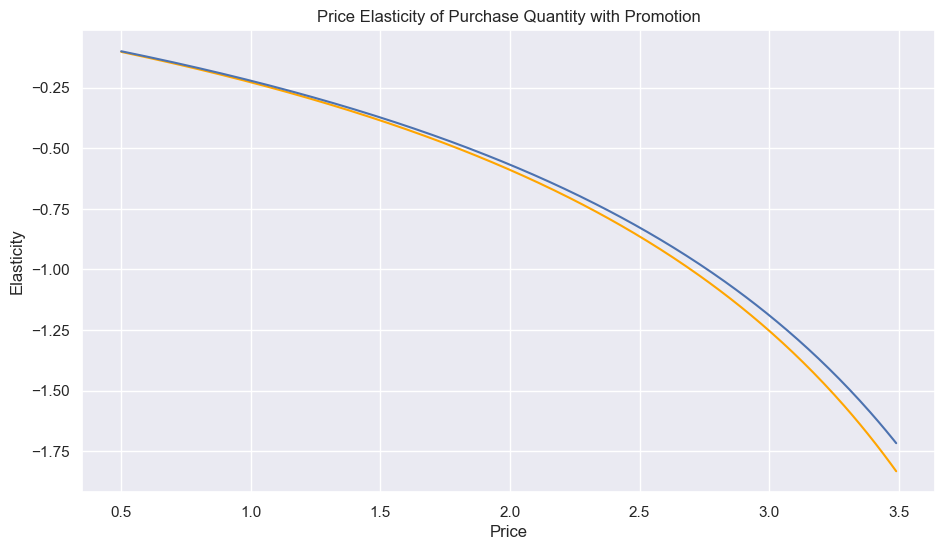

In [116]:
# Plotting the two elasticities side by side. 
plt.figure(figsize = (11, 6))
plt.plot(price_range, price_elasticity_quantity_promotion_yes, color = 'orange')
plt.plot(price_range, price_elasticity_quantity_promotion_no)
plt.xlabel('Price')
plt.ylabel('Elasticity')
plt.title('Price Elasticity of Purchase Quantity with Promotion')

- Two elasticities are very close together for almost the entire price range.
- It appears that promotion does not appear to be a significant factor in the customers' decision of what quantity of chocolate candy bars to purchase.